In [3]:
import os
import pandas as pd
import sqlalchemy as sql
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import scipy.optimize as sco

# https://pypi.org/project/yfinance/
import yfinance as yf

import plotly.graph_objects as go
import hvplot.pandas
import holoviews as hv
import seaborn as sns
import copy
import warnings

from pathlib import Path
# https://pandas-datareader.readthedocs.io/en/latest/
from pandas_datareader import data as pdr
from pandas import Timestamp as tstamp
from pandas import read_csv as rcsv
from pandas import read_sql_query as rsqq
from sqlalchemy import (
    create_engine as ce,
    inspect
)

# Import date and timedelta class
from datetime import date
from datetime import timedelta
from scipy import stats

# https://pyportfolioopt.readthedocs.io/en/latest/index.html
from pypfopt import(                        
    EfficientFrontier,
    risk_models,
    expected_returns,
    plotting
)

# https://pyportfolioopt.readthedocs.io/en/latest/index.html
from pypfopt.discrete_allocation import(    
    DiscreteAllocation,
    get_latest_prices
)

from MCForecastTools import MCSimulation
from calculations import MPTCalculations as mpt
from metrics import QuantMetrics as qm
from dataset import DataCollection as ds

warnings.filterwarnings('ignore')

print(f"Package imports and dependencies resolved")

Package imports and dependencies resolved


### Modern Portfolio Theory Based Portfolio Analysis and Optimization

---
Steps Involved:
1. Project Settings
2. Data Preparation (Fetch, Clean and Format)
3. Quant Analysis
4. Visualizations
5. Summary

### 1. Project Settings

In [4]:
# Specifiy date range for data
# Set start and end dates of 5 years "5Y" back from your current date
end_date = pd.to_datetime('today')
# 5 years
start_date = end_date - np.timedelta64(5, 'Y')
start, end = start_date, end_date
# Verify date range
print(f"Start date: {start} and End date: {end}")

Start date: 2017-10-18 11:29:51.460523 and End date: 2022-10-18 16:35:51.460523


In [5]:
# Specify portfolio sectors - basket of market index and assets - S&P 500 Index (^GSPC) and Tech Stocks List
basket_list = ds.market + ds.tech_list

print("Basket of stocks")
print(basket_list)

Basket of stocks
['^GSPC', 'AAPL', 'IBM', 'TSLA', 'GOOGL', 'MSFT', 'CSCO', 'TSM', 'NVDA']


### 2. Data Preparation

In [6]:
# Dataframe closing prices of basket, i.e. market index and assets
# Fetch data from Yahoo Finance API
stock_data, raw_data = ds.get_raw_data(basket_list, start, end)
stock_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)
stock_data = stock_data.reset_index()
raw_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)

In [7]:
# Output raw data is raw_frame_close
display(raw_data.shape)
# Review random 5 rows from dataframe
display(raw_data.sample(5))

(1259, 54)

Attributes    Adj Close                                                  \
Symbols     SP500_Index        AAPL         IBM        TSLA       GOOGL   
Date                                                                      
2021-03-15  3968.939941  122.905869  114.344063  235.979996  102.722000   
2019-12-19  3205.370117   68.696098  112.199844   26.936001   67.821999   
2022-04-29  4131.930176  157.200348  129.000137  290.253326  114.109497   
2020-03-31  2584.590088   62.531921   93.462357   34.933334   58.097500   
2020-02-06  3345.780029   79.782349  130.710800   49.930668   73.798500   

Attributes                                                       Close  ...  \
Symbols           MSFT       CSCO         TSM        NVDA  SP500_Index  ...   
Date                                                                    ...   
2021-03-15  231.879410  46.918999  115.385056  131.753418  3968.939941  ...   
2019-12-19  151.805130  43.601933   54.706440   58.676903  3205.370117  ...   
2022-04-29  276.288666  48.096336   91.923203  185.375717  4131.930176  ...   
2020-03-31  154.174973  36.060818   45.535275   65.728706  2584.590088  ...   
2020-02-06  179.024948  44.665520   54.763069   63.359386  3345.780029  ...   

Attributes        Open        Volume                                       \
Symbols           NVDA   SP500_Index         AAPL        IBM         TSLA   
Date                                                                        
2021-03-15  128.647507  4.882190e+09   92403800.0  3577948.0   88006800.0   
2019-12-19   57.724998  3.720450e+09   98369200.0  4044359.0  271606500.0   
2022-04-29  194.020004  3.943480e+09  131747600.0  5078700.0   88133100.0   
2020-03-31   66.800003  6.568290e+09  197002000.0  6635092.0  266572500.0   
2020-02-06   63.035000  3.868370e+09  105425600.0  8786923.0  598212000.0   

Attributes                                                              
Symbols          GOOGL        MSFT        CSCO         TSM        NVDA  
Date                                                                    
2021-03-15  26168000.0  26034900.0  15523600.0   8935000.0  22198800.0  
2019-12-19  28922000.0  24958900.0  30764700.0   7228700.0  44536000.0  
2022-04-29  42676000.0  37073900.0  20281400.0  10629300.0  50043500.0  
2020-03-31  65228000.0  77927200.0  26014200.0   9595700.0  94996000.0  
2020-02-06  37822000.0  27751400.0   9814800.0   4236300.0  21828400.0  

[5 rows x 54 columns]

In [8]:
# Output cleaned data to 'Close' prices is stock_data, cut table down to 29 columns from 174 columns
display(stock_data.shape)
# Review random 5 rows from dataframe
display(stock_data.sample(5)) 

(1259, 10)

Symbols       Date  SP500_Index       AAPL         IBM       TSLA      GOOGL  \
486     2019-09-25  2984.870117  55.257500  136.864243  15.246667  62.297001   
598     2020-03-06  2972.370117  72.257500  122.112808  46.898666  64.787003   
423     2019-06-26  2913.780029  49.950001  132.428299  14.618000  54.015999   
361     2019-03-28  2815.439941  47.180000  133.766724  18.574667  58.613499   
156     2018-06-04  2746.870117  47.957500  136.749527  19.782667  57.652000   

Symbols        MSFT       CSCO        TSM       NVDA  
486      139.360001  49.610001  45.009998  44.557499  
598      161.570007  39.680000  55.070000  66.510002  
423      133.929993  56.599998  39.080002  39.814999  
361      116.930000  53.360001  40.340000  44.312500  
156      101.669998  43.580002  39.970001  66.212502

In [9]:
# Import the [offline stored] data from the csv file
# Generate dataframe setting the DatetimeIndex with 'date' as as index. 
working_raw_data = rcsv(
    Path('data/raw_frame_close.csv'),
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True,
    header = [0,1]
)

# Output dataframe name is working_raw_frame_close
print('Sample row of DataFrame from local csv data source path:')
display(working_raw_data.shape)

# Display sample 5 rows of dataframe
display(working_raw_data.sample(5))

Sample row of DataFrame from local csv data source path:


(1259, 54)

Attributes    Adj Close                                                  \
Symbols           ^GSPC        AAPL         IBM        TSLA       GOOGL   
Date                                                                      
2022-02-09  4587.180176  175.777206  132.844452  310.666656  141.591995   
2019-02-13  2753.030029   41.307919  110.694756   20.544666   56.431499   
2021-01-06  3748.139893  125.305794  113.459312  251.993332   86.143997   
2018-09-07  2871.679932   53.300945  114.274094   17.549334   58.879501   
2018-02-16  2732.219971   41.226311  120.059937   22.365999   54.775002   

Attributes                                                       Close  ...  \
Symbols           MSFT       CSCO         TSM        NVDA        ^GSPC  ...   
Date                                                                    ...   
2022-02-09  309.189880  54.898510  123.564194  266.868744  4587.180176  ...   
2019-02-13  102.614182  42.393085   34.366974   37.949661  2753.030029  ...   
2021-01-06  209.119339  42.161575  112.022720  125.949387  3748.139893  ...   
2018-09-07  103.512009  41.389000   40.450825   67.416801  2871.679932  ...   
2018-02-16   87.290047  38.386089   37.806274   60.360386  2732.219971  ...   

Attributes        Open        Volume                                       \
Symbols           NVDA         ^GSPC         AAPL        IBM         TSLA   
Date                                                                        
2022-02-09  256.220001  3.662810e+09   71285000.0  5393500.0   52259400.0   
2019-02-13   38.090000  3.670770e+09   89960800.0  4448638.0   77124000.0   
2021-01-06  132.225006  6.049970e+09  155088000.0  8322708.0  134100000.0   
2018-09-07   67.250000  2.946270e+09  150479200.0  4908983.0  337378500.0   
2018-02-16   61.349998  3.637460e+09  160704400.0  4479913.0   84639000.0   

Attributes                                                              
Symbols          GOOGL        MSFT        CSCO         TSM        NVDA  
Date                                                                    
2022-02-09  40144000.0  31284700.0  19136700.0  10979700.0  52428200.0  
2019-02-13  28042000.0  18394900.0  28325600.0   7155600.0  60537200.0  
2021-01-06  46588000.0  35930700.0  21823100.0  10609300.0  58042400.0  
2018-09-07  32658000.0  22498600.0  17229700.0  14256000.0  29542000.0  
2018-02-16  39948000.0  30596900.0  39267500.0   4792100.0  63765600.0  

[5 rows x 54 columns]

In [10]:
# Verify Close columns of each stocks and index
working_raw_data['Close']

Symbols           ^GSPC        AAPL         IBM        TSLA       GOOGL  \
Date                                                                      
2017-10-18  2561.260010   39.939999  152.514343   23.976667   50.637001   
2017-10-19  2562.100098   38.994999  153.824097   23.454000   50.091999   
2017-10-20  2575.209961   39.062500  154.942642   23.006666   50.253502   
2017-10-23  2564.979980   39.042500  152.533463   22.468000   49.277000   
2017-10-24  2569.129883   39.275002  149.024857   22.489332   49.424500   
...                 ...         ...         ...         ...         ...   
2022-10-12  3577.030029  138.339996  117.570000  217.240005   97.559998   
2022-10-13  3669.909912  142.990005  121.790001  221.720001   99.059998   
2022-10-14  3583.070068  138.380005  120.040001  204.990005   96.559998   
2022-10-17  3677.949951  142.410004  121.519997  219.350006   99.970001   
2022-10-18  3719.979980  143.750000  122.940002  220.190002  100.769997   

Symbols           MSFT       CSCO        TSM        NVDA  
Date                                                      
2017-10-18   77.610001  33.549999  41.500000   49.395000  
2017-10-19   77.910004  33.750000  41.070000   49.450001  
2017-10-20   78.809998  34.250000  41.119999   49.224998  
2017-10-23   78.830002  34.349998  41.209999   49.154999  
2017-10-24   78.860001  34.580002  41.320000   49.669998  
...                ...        ...        ...         ...  
2022-10-12  225.750000  39.270000  64.110001  115.000000  
2022-10-13  234.240005  40.610001  66.620003  119.599998  
2022-10-14  228.559998  40.200001  63.919998  112.269997  
2022-10-17  237.529999  41.299999  64.889999  118.879997  
2022-10-18  238.500000  41.790001  63.709999  119.669998  

[1259 rows x 9 columns]

### START SQlite
#### Input pandas dataframe is **raw_frame_close** 
#### SQlite database table name is basket
#### Output pandas dataframe name is sql_basket_df

In [11]:
# Fetch date indexed and unindexed data frames created out of SQLite temp db
sql_basket_indexed_df, sql_basket_df = ds.sqlite_data(stock_data)

print("Unindexed dataframe counts and column summary")
display(sql_basket_df.shape) 
# Display sample 5 rows of unindexed dataframe
display(sql_basket_df.sample(5))

print("Indexed dataframe counts and column summary")
display(sql_basket_indexed_df.shape) 

# Display sample 5 rows of indexed datafarme
display(sql_basket_indexed_df.sample(5))

Unindexed dataframe counts and column summary


(1259, 10)

Date  SP500_Index        AAPL         IBM        TSLA       GOOGL  \
972 2021-08-30  4528.790039  153.119995  132.858505  243.636673  144.590500   
799 2020-12-21  3694.919922  128.229996  117.963669  216.619995   86.727997   
734 2020-09-18  3319.469971  106.839996  117.361374  147.383331   72.554497   
303 2019-01-03  2447.889893   35.547501  107.944550   20.024000   51.273499   
190 2018-07-23  2806.979980   47.902500  139.292542   20.213333   60.549999   

           MSFT       CSCO         TSM        NVDA  
972  303.589996  59.130001  118.989998  226.880005  
799  222.589996  44.880001  104.830002  133.322495  
734  200.389999  39.810001   80.230003  121.892502  
303   97.400002  41.070000   34.360001   31.997499  
190  107.970001  42.060001   40.740002   62.352501

Indexed dataframe counts and column summary


(1259, 9)

SP500_Index        AAPL         IBM        TSLA       GOOGL  \
Date                                                                      
2019-06-19  2926.459961   49.467499  131.051620   15.095333   55.225498   
2018-10-17  2809.209961   55.297501  128.154877   18.118668   56.379501   
2021-03-11  3939.340088  121.959999  121.548759  233.199997  105.027000   
2017-10-19  2562.100098   38.994999  153.824097   23.454000   50.091999   
2017-10-24  2569.129883   39.275002  149.024857   22.489332   49.424500   

                  MSFT       CSCO         TSM        NVDA  
Date                                                       
2019-06-19  135.690002  56.130001   39.400002   38.279999  
2018-10-17  110.709999  45.939999   39.570000   60.764999  
2021-03-11  237.130005  48.799999  120.580002  129.934998  
2017-10-19   77.910004  33.750000   41.070000   49.450001  
2017-10-24   78.860001  34.580002   41.320000   49.669998

### 3. Quant Analysis

In [154]:
# Display constants being used in quant analysis
print("Number of trading days per year = ", qm.num_trading_days)
print("Risk free rate = ", qm.risk_free_rate)
print("Number of random portfolio runs = ", qm.num_random_portfolio_run)
print("Number of days in rolling window = ", qm.rolling_window_days)
print("Number of days of input dataframe to use as historical data = ", mpt.historical_days_percent)
print("Number of days of input dataframe to use as test/experiment data  = ", mpt.test_days_percent)

Number of trading days per year =  252
Risk free rate =  0.0275
Number of random portfolio runs =  10000
Number of days in rolling window =  20
Number of days of input dataframe to use as historical data =  0.75
Number of days of input dataframe to use as test/experiment data  =  0.25


In [155]:
# Break up the input asset price data frame into 2 chunks
# (1) For use of historical data to determine what the optimum portfolio selection should be
# (2) For test purposes,test how wll the portfolio allocation performs
num_days_total = sql_basket_indexed_df.shape[0]
num_historical_days_percent = round(num_days_total * mpt.historical_days_percent)
num_test_days_percent = round(num_days_total * mpt.test_days_percent)

print("Total # of days in asset dataframe = ", num_days_total)
print("Total # of days will use for hisotrical data = ", num_historical_days_percent)
print("Total # of days will use for testing results = ", num_test_days_percent)


# Extract the days from full dataframe will use for historical data
asset_mkt_prices_historical_df = sql_basket_indexed_df.iloc[0:num_historical_days_percent-1, :].copy()
asset_mkt_prices_test_df = sql_basket_indexed_df.iloc[num_historical_days_percent:num_days_total-1,:].copy()

Total # of days in asset dataframe =  1259
Total # of days will use for hisotrical data =  944
Total # of days will use for testing results =  315


In [156]:
# Plot the asset prices
asset_mkt_prices_historical_df.hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="Performance of Historical Market & Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [157]:
# Plot the asset prices
asset_mkt_prices_test_df.hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="(Test) Market & Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

#### Calculate Descriptive Stats
---
* Asset Returns, Standard Deviation, Cumulative Returns, Covariance, Correlation Matrix, Sharpe Ratio

In [158]:
# Compute the frequency components on asset prices
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_mkt_prices_historical_df)

In [159]:
# Review daily returns DataFrame.
print("Asset Returns:")
display(asset_mkt_prices_returns_df.shape)
# Display randow 5 rows of the returns
display(asset_mkt_prices_returns_df.sample(5))

Asset Returns:


(942, 9)

SP500_Index      AAPL       IBM      TSLA     GOOGL      MSFT  \
Date                                                                        
2021-03-29    -0.000868  0.001485 -0.003813 -0.011993  0.010401 -0.005244   
2020-11-13     0.013610  0.000419  0.020524 -0.007917  0.016892  0.004967   
2018-06-07    -0.000714 -0.002681  0.004492 -0.010673 -0.010925 -0.015709   
2019-03-14    -0.000868  0.011117  0.001660  0.003461 -0.005446  0.000786   
2019-03-12     0.002953  0.011235  0.004139 -0.025987  0.015255  0.007002   

                CSCO       TSM      NVDA  
Date                                      
2021-03-29 -0.000951 -0.018617  0.008490  
2020-11-13  0.070597  0.037854 -0.011871  
2018-06-07 -0.013782 -0.001011 -0.008486  
2019-03-14  0.002852 -0.009946 -0.018147  
2019-03-12  0.004430  0.006729  0.008564

In [160]:
# Plot the asset cumulative returns
asset_mkt_prices_cum_returns_df.hvplot.line(
    ylabel="Cum Returns", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="Market & Assets Cumulative Returns"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Asset & Market: Daily Returns Box Plot'}>

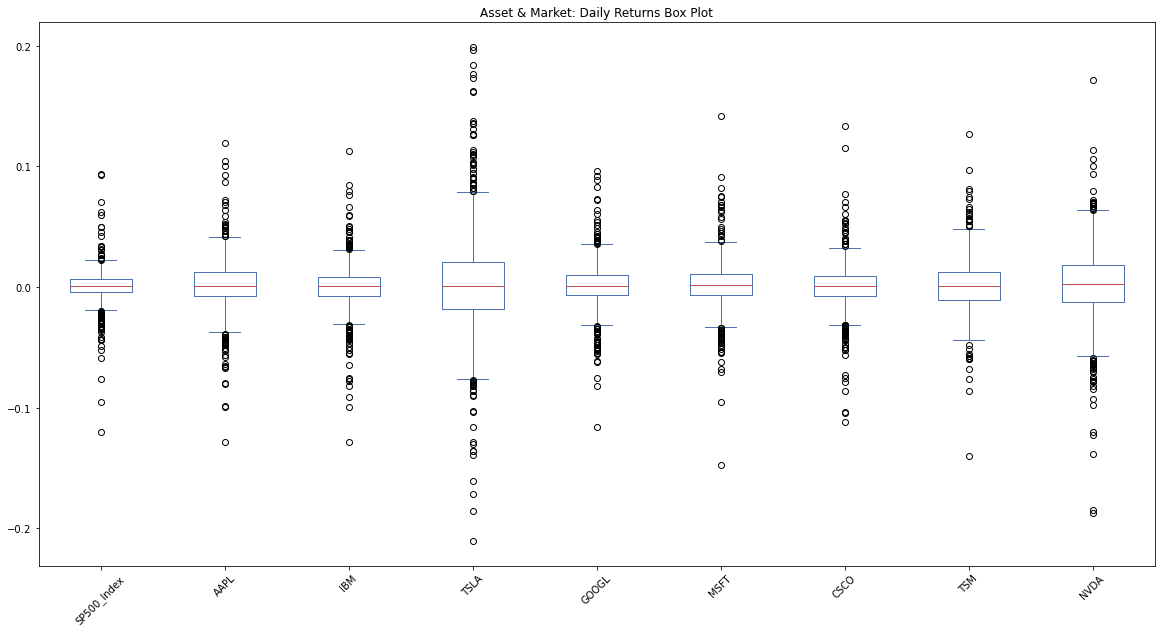

In [161]:
# Use the daily return data to create box plots to visualize the volatility of the assets 
asset_mkt_prices_returns_df.plot.box(figsize=(20, 10), rot=45, title = "Asset & Market: Daily Returns Box Plot")

In [162]:
# Sort the asset deviations
asset_mkt_prices_ann_std_sorted_df = asset_mkt_prices_ann_std_df.sort_values()

print("Asset annualized standard deviations (Sorted):")
display(asset_mkt_prices_ann_std_sorted_df)

Asset annualized standard deviations (Sorted):


SP500_Index    0.215597
IBM            0.286931
GOOGL          0.295233
CSCO           0.296555
MSFT           0.304197
AAPL           0.334059
TSM            0.340231
NVDA           0.480390
TSLA           0.656076
dtype: float64

In [163]:
# Dispaly the (sorted) asset sharpe ratios
print("Assets & Market: Annual Sharpe Ratio (Sorted):")
display(asset_prices_sharpe_ratio_df.sort_values())

asset_prices_sharpe_ratio_df.hvplot(
    kind = 'bar',
    width = 800,
    height = 500,
    hover_color = 'magenta',
    rot = 45,
    title = "Assets & Market: Annual Sharpe Ratio")

Assets & Market: Annual Sharpe Ratio (Sorted):


IBM            0.008716
CSCO           0.562203
SP500_Index    0.739498
GOOGL          0.963853
TSM            0.974125
NVDA           0.987275
AAPL           1.186144
TSLA           1.222170
MSFT           1.271766
dtype: float64

:Bars   [index]   (0)

In [164]:
# Drop the market from asset/mkt data frame
asset_prices_df = asset_mkt_prices_historical_df.drop(['SP500_index'], axis=1, inplace=False)
print("Asset Prices DataFrame (does not include market)")
display(asset_prices_df)

# Recompute frequence components (e.g. covariance matrix will be different).  TODO: Optimize dataframe creating by sharing data
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_prices_df)

Asset Prices DataFrame (does not include market)


AAPL         IBM        TSLA       GOOGL        MSFT  \
Date                                                                     
2017-10-18   39.939999  152.514343   23.976667   50.637001   77.610001   
2017-10-19   38.994999  153.824097   23.454000   50.091999   77.910004   
2017-10-20   39.062500  154.942642   23.006666   50.253502   78.809998   
2017-10-23   39.042500  152.533463   22.468000   49.277000   78.830002   
2017-10-24   39.275002  149.024857   22.489332   49.424500   78.860001   
...                ...         ...         ...         ...         ...   
2021-07-13  145.639999  134.110901  222.846664  127.341499  280.980011   
2021-07-14  149.149994  133.671127  217.793335  128.237000  282.510010   
2021-07-15  148.479996  134.273422  216.866669  127.004997  281.029999   
2021-07-16  146.389999  132.791580  214.740005  126.970001  280.750000   
2021-07-19  142.449997  131.854691  215.406662  124.578003  277.010010   

                 CSCO         TSM        NVDA  
Date                                           
2017-10-18  33.549999   41.500000   49.395000  
2017-10-19  33.750000   41.070000   49.450001  
2017-10-20  34.250000   41.119999   49.224998  
2017-10-23  34.349998   41.209999   49.154999  
2017-10-24  34.580002   41.320000   49.669998  
...               ...         ...         ...  
2021-07-13  53.320000  123.900002  202.500000  
2021-07-14  54.090000  124.389999  198.414993  
2021-07-15  53.650002  117.529999  189.662506  
2021-07-16  53.700001  115.739998  181.610001  
2021-07-19  53.060001  115.349998  187.797501  

[943 rows x 8 columns]

In [165]:
print("Annual Covariance Matrix:")
# TODO: display(asset_prices_ann_cov_mtrx_df.head())

display(asset_mkt_prices_ann_cov_mtrx_df.head())

print("Correlation Matrix:")
# TODO display(asset_prices_ann_corr_mtrx_df.head())
display(asset_mkt_prices_ann_corr_mtrx_df)

Annual Covariance Matrix:


AAPL       IBM      TSLA     GOOGL      MSFT      CSCO       TSM  \
AAPL   0.111595  0.045578  0.092344  0.066799  0.076999  0.060046  0.064491   
IBM    0.045578  0.082329  0.044179  0.043538  0.047714  0.054138  0.043616   
TSLA   0.092344  0.044179  0.430436  0.072725  0.086827  0.054394  0.081187   
GOOGL  0.066799  0.043538  0.072725  0.087163  0.071124  0.052017  0.053407   
MSFT   0.076999  0.047714  0.086827  0.071124  0.092536  0.061016  0.060100   

           NVDA  
AAPL   0.103660  
IBM    0.059229  
TSLA   0.132986  
GOOGL  0.090669  
MSFT   0.102463

Correlation Matrix:


AAPL       IBM      TSLA     GOOGL      MSFT      CSCO       TSM  \
AAPL   1.000000  0.475503  0.421340  0.677300  0.757720  0.606113  0.567416   
IBM    0.475503  1.000000  0.234684  0.513961  0.546659  0.636237  0.446780   
TSLA   0.421340  0.234684  1.000000  0.375458  0.435055  0.279570  0.363711   
GOOGL  0.677300  0.513961  0.375458  1.000000  0.791953  0.594122  0.531686   
MSFT   0.757720  0.546659  0.435055  0.791953  1.000000  0.676373  0.580695   
CSCO   0.606113  0.636237  0.279570  0.594122  0.676373  1.000000  0.487977   
TSM    0.567416  0.446780  0.363711  0.531686  0.580695  0.487977  1.000000   
NVDA   0.645942  0.429696  0.421947  0.639296  0.701161  0.548837  0.625009   

           NVDA  
AAPL   0.645942  
IBM    0.429696  
TSLA   0.421947  
GOOGL  0.639296  
MSFT   0.701161  
CSCO   0.548837  
TSM    0.625009  
NVDA   1.000000

[Text(0.5, 1.0, 'Asset Prices Correlation Matrix')]

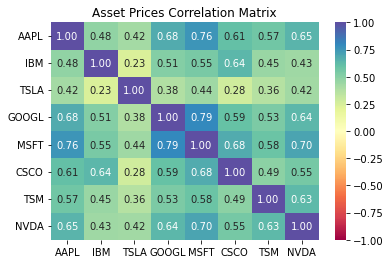

In [166]:
# Use the `heatmap` function from the seaborn library to visualize the correlation matrix
sns.heatmap(
    asset_mkt_prices_ann_corr_mtrx_df, 
    annot=True, 
    vmin=-1, 
    vmax=1, 
    fmt=".2f", 
    cmap="Spectral"
).set(
    title='Asset Prices Correlation Matrix')

In [167]:
print("Annual average asset returns:")
display(asset_mkt_prices_ann_returns_mean)

Annual average asset returns:


AAPL     0.396242
IBM      0.002501
TSLA     0.801837
GOOGL    0.284562
MSFT     0.386867
CSCO     0.166724
TSM      0.331428
NVDA     0.474277
dtype: float64

### Efficient Frontier Computation

In [168]:
# Determine the efficient frontier components
efficient_frontier_df = qm.mpt_qa_get_efficient_frontier(asset_prices_df, asset_mkt_prices_ann_returns_mean, asset_mkt_prices_ann_cov_mtrx_df)

print("Efficient Frontier DataFrame:")
display(efficient_frontier_df.shape)

print("Print random 5 rows of Efficient Frontier sample points")
display(efficient_frontier_df.sample(5))

Efficient Frontier DataFrame:


(10000, 11)

Print random 5 rows of Efficient Frontier sample points


Returns  Volatility  SharpeRatio    AAPL_W     IBM_W    TSLA_W  \
878   0.249321    4.135897     0.053633  0.030555  0.257209  0.006169   
4525  0.305619    4.271393     0.065112  0.137308  0.245401  0.134449   
69    0.345314    4.546608     0.069901  0.067917  0.143093  0.082372   
4616  0.234698    4.142500     0.050018  0.165475  0.229258  0.005407   
9695  0.359472    4.684251     0.070870  0.162113  0.141422  0.077469   

       GOOGL_W    MSFT_W    CSCO_W     TSM_W    NVDA_W  
878   0.042458  0.226479  0.166346  0.169657  0.101125  
4525  0.077740  0.133375  0.165803  0.061664  0.044260  
69    0.013711  0.221333  0.117080  0.176275  0.178218  
4616  0.120304  0.022407  0.278860  0.068129  0.110160  
9695  0.064677  0.124160  0.048731  0.158910  0.222518

Text(0.5, 1.0, 'Efficient Frontier')

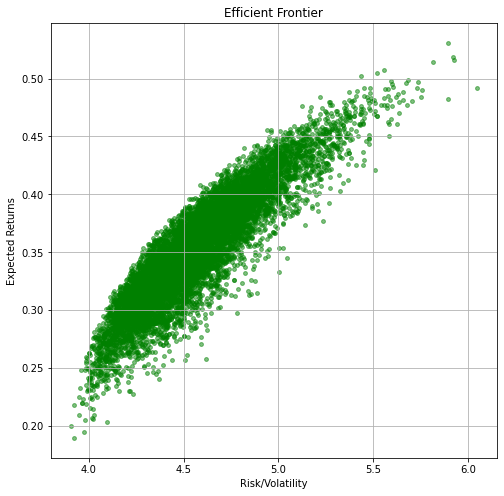

In [169]:
# Plot the efficient frontier #1 (Just the plain efficient frontier)
efficient_frontier_df.plot(
    kind = "scatter",
    x = 'Volatility',
    y = 'Returns',
    color = 'g',
    marker = 'o',
    s = 15,
    alpha = 0.5,
    grid = True,
    figsize = [8,8]
)
plt.xlabel('Risk/Volatility')
plt.ylabel('Expected Returns')
plt.title("Efficient Frontier")

In [170]:
# Select the following portfolio allocations:
# (1) Based on the "minimum" risk
# (2) Based on the "maximum" risk
# (3) Based on the "optimum sharpe ratio"
portfolio_min_volatility, portfolio_max_volatility, portfolio_opt_sharpe_ratio = qm.mpt_qa_return_portfolio_allocations(efficient_frontier_df)

print("Efficient Frontier: Min Volatility Point:")
display(portfolio_min_volatility)
print("\nEfficient Frontier: Max Volatility Point:")
display(portfolio_max_volatility)
print("\nEfficient Frontier: Opt Sharpe Ratio Volatility Point:")
display(portfolio_opt_sharpe_ratio)

Efficient Frontier: Min Volatility Point:


Returns        0.200095
Volatility     3.906508
SharpeRatio    0.044181
AAPL_W         0.050499
IBM_W          0.313278
TSLA_W         0.023039
GOOGL_W        0.262622
MSFT_W         0.008181
CSCO_W         0.201602
TSM_W          0.122151
NVDA_W         0.018627
Name: 2515, dtype: float64


Efficient Frontier: Max Volatility Point:


Returns        0.491565
Volatility     6.043928
SharpeRatio    0.076782
AAPL_W         0.004631
IBM_W          0.205169
TSLA_W         0.432011
GOOGL_W        0.027829
MSFT_W         0.137315
CSCO_W         0.003828
TSM_W          0.060253
NVDA_W         0.128964
Name: 8031, dtype: float64


Efficient Frontier: Opt Sharpe Ratio Volatility Point:


Returns        0.476063
Volatility     5.123023
SharpeRatio    0.087558
AAPL_W         0.229123
IBM_W          0.008434
TSLA_W         0.242831
GOOGL_W        0.001940
MSFT_W         0.290752
CSCO_W         0.017120
TSM_W          0.173953
NVDA_W         0.035847
Name: 4530, dtype: float64

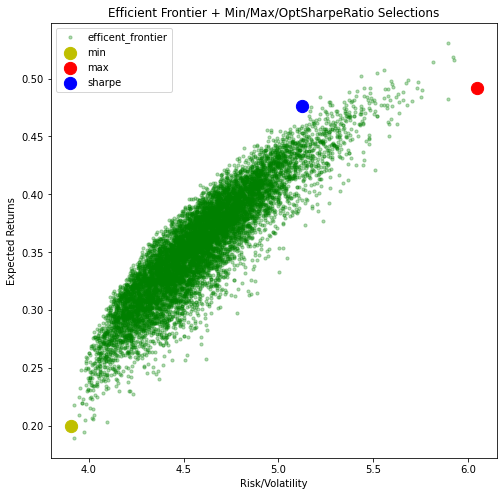

In [171]:
# Plot the efficient frontier #2 (Efficient frontier with selected portfolio points)

plt.subplots(figsize=(8,8))

plt.scatter(
    efficient_frontier_df['Volatility'],
    efficient_frontier_df['Returns'],
    color = 'g',
    marker = 'o',
    s = 10,
    alpha = 0.3
)

plt.scatter(portfolio_min_volatility[1], portfolio_min_volatility[0], color='y', marker='o', s=150)
plt.scatter(portfolio_max_volatility[1], portfolio_max_volatility[0], color='r', marker='o', s=150)
plt.scatter(portfolio_opt_sharpe_ratio[1], portfolio_opt_sharpe_ratio[0], color='b', marker='o', s=150)

plt.xlabel('Risk/Volatility')
plt.ylabel('Expected Returns')
plt.title("Efficient Frontier + Min/Max/OptSharpeRatio Selections")
plt.legend(["efficent_frontier", "min" , "max", "sharpe"])

In [174]:
# Plot the efficient frontier #3 (Efficient frontier + porfolio selection points + 3rd color dimension of the sharpe ratio points)
scatter = hv.Scatter((efficient_frontier_df['Volatility'], efficient_frontier_df['Returns'], efficient_frontier_df.loc[:,'SharpeRatio']), 'Volatility', ['Return', 'Sharpe Ratio'])
max_sharpe = hv.Scatter([(portfolio_opt_sharpe_ratio[1],portfolio_opt_sharpe_ratio[0])])
min_volatility = hv.Scatter([(portfolio_min_volatility[1],portfolio_min_volatility[0])])
max_volatility = hv.Scatter([(portfolio_max_volatility[1],portfolio_max_volatility[0])])

scatter.opts(title="Efficient Frontier + Min/Max/OptSharpeRatio Selections", color='Sharpe Ratio', cmap='plasma', width=800, height=600, colorbar=True, padding=0.1) *\
max_sharpe.opts(color='blue', line_color='black', size=15,) *\
min_volatility.opts(color='yellow', line_color='black', size=15) *\
max_volatility.opts(color='red', line_color='black', size=15)


:Overlay
   .Scatter.I   :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Scatter.II  :Scatter   [x]   (y)
   .Scatter.III :Scatter   [x]   (y)
   .Scatter.IV  :Scatter   [x]   (y)

### Visualization for: "mpt_performance_eval.py"

KeyError: 'SP500_Index'

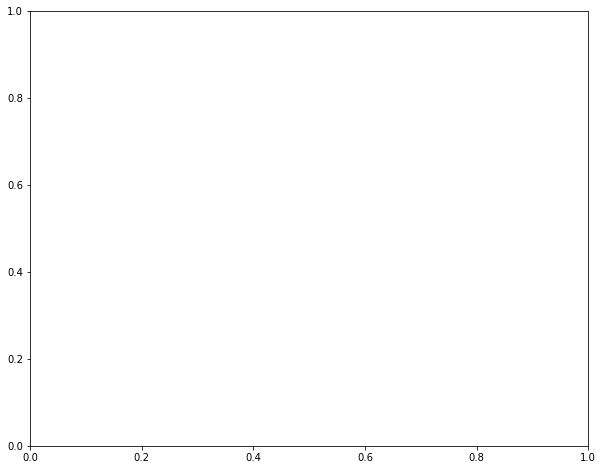

In [173]:
portfolio_min_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_min_volatility)
portfolio_max_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_max_volatility)
portfolio_opt_sharpe_ratio_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_opt_sharpe_ratio)

plt.subplots(figsize=(10,8))

sns.regplot(asset_mkt_prices_returns_df['SP500_index'], portfolio_max_volatility_returns_df, color='r')
sns.regplot(asset_mkt_prices_returns_df['SP500_index'], portfolio_opt_sharpe_ratio_volatility_returns_df, color='b')
sns.regplot(asset_mkt_prices_returns_df['SP500_index'], portfolio_min_volatility_returns_df, color='y')
plt.xlabel("Market Returns (yellow=Min, blue=OptSharpe, red=Max")
plt.ylabel("Portfolio Returns")
plt.legend(["Max", "", "", "OptSharpe", "", "", "Min"])
plt.title("Combininig Min/Max/OptSharpe Portfolio Selection Returns vs Market Returns")
plt.show()

# TODO:  Clean up legend (not sure how to do exclude parts of legend)

# TODO: Not running at the moment


<AxesSubplot:title={'center':'Portfolio Composition - Min Protfolio'}, ylabel='weights'>

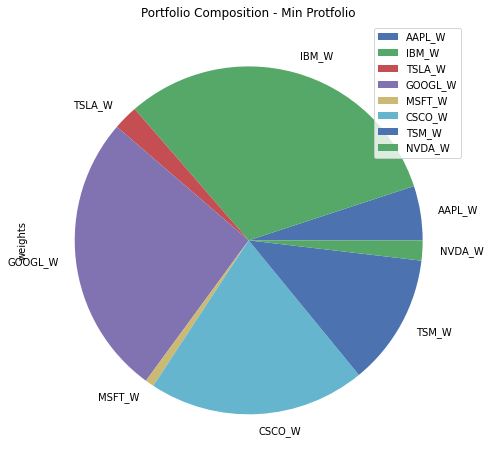

In [175]:
portfolio_min_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_min_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_min_weights.plot.pie(
    y='weights', 
    title='Portfolio Composition - Min Protfolio',
    figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Max Protfolio'}, ylabel='weights'>

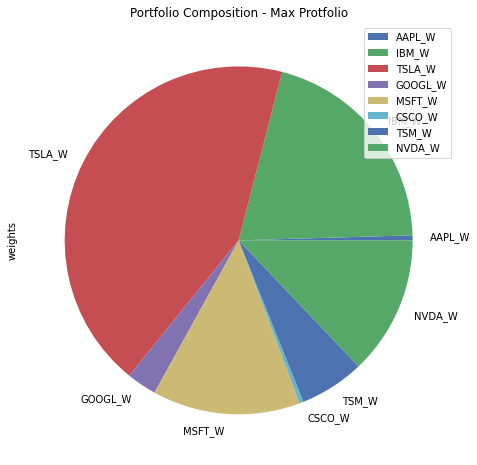

In [176]:
portfolio_max_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_max_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_max_weights.plot.pie(y='weights', title='Portfolio Composition - Max Protfolio', figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Opt Sharpe Ratio Protfolio'}, ylabel='weights'>

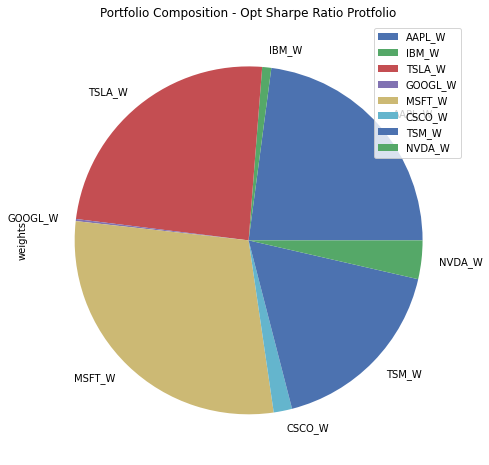

In [177]:
portfolio_opt_sharpe_ratio_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_opt_sharpe_ratio)

# Plot the pie charts of the porfolio allocation/weights
portfolio_opt_sharpe_ratio_weights.plot.pie(y='weights', title='Portfolio Composition - Opt Sharpe Ratio Protfolio', figsize=(10,8))

### Compute Actual Realized Portfolio Value under the Test dataframe components

In [178]:
asset_prices_test_beg_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_historical_days_percent, :]).drop('SP500_index', axis=0, inplace=False)
asset_prices_test_end_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_days_total-1, :]).drop('SP500_index', axis=0, inplace=False)

print("Beginning and end dates used for the testing the performance of the portfolio")
display(asset_prices_test_beg_df.T)
display(asset_prices_test_end_df.T)

Beginning and end dates used for the testing the performance of the portfolio


AAPL         IBM        TSLA       GOOGL        MSFT  \
2021-07-21  145.399994  135.086044  218.429993  127.549004  281.399994   

                 CSCO         TSM        NVDA  
2021-07-21  53.880001  117.870003  194.100006

AAPL         IBM        TSLA       GOOGL   MSFT       CSCO  \
2022-10-18  143.75  123.129997  220.190002  100.769997  238.5  41.790001   

                  TSM        NVDA  
2022-10-18  63.740002  119.669998

### Monte-Carlo Dataframe Weights List

In [179]:
# Arrange Monte Carlo dataframe weights list
portfolio_mc_min_weights = mpt.mpt_pe_get_mc_weights(portfolio_min_weights)
portfolio_mc_max_weights = mpt.mpt_pe_get_mc_weights(portfolio_max_weights)
portfolio_mc_opt_sharpe_ratio_weights = mpt.mpt_pe_get_mc_weights(portfolio_opt_sharpe_ratio_weights)

In [180]:
investment_pnl_min = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_min_weights))[0][0]
investment_pnl_max = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_max_weights))[0][0]
investment_pnl_opt_sharpe_ratio = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_opt_sharpe_ratio_weights))[0][0]

print("Actual realized portfolio value for min/max/opt_sharpe allocations:")
display(investment_pnl_min)
display(investment_pnl_max)
display(investment_pnl_opt_sharpe_ratio)

Actual realized portfolio value for min/max/opt_sharpe allocations:


7902.899917602539

8842.969997406006

8551.030048370361

### Run Monte-Carlo Simulations
---
* Compute expected Returns, and 
* Compare against realized returns

In [181]:
print("Number of MC runs:", mpt.num_mc_runs)

Number of MC runs: 500


In [182]:
# Slice the "test" dataframe to use for MC sims to predict returns
asset_mc_test_df = asset_mkt_prices_test_df.drop('SP500_index', axis=1, inplace=False)

In [183]:
# Arrange Monte Carlo dataframe to have tuples for column names
asset_prices_mc_col_df = mpt.mpt_pe_get_mc_porfolio_df(asset_mc_test_df)

In [184]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_min_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_min_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = qm.num_trading_days * mpt.num_mc_years
)

# Review the simulation input data
print("Monte Carlo Portfolio (Min)")
MC_min_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Min)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-11  138.979996    -0.010255  117.800003     0.000425  216.500000   
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   

                             GOOGL                     MSFT               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2022-10-11    -0.028974  97.180000    -0.006949  225.410004    -0.016750   
2022-10-12     0.003418  97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622  99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456  96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052  99.970001     0.035315  237.529999     0.039246   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-11  39.580002    -0.007771  63.450001    -0.059164  115.860001   
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   

                         
           daily_return  
Date                     
2022-10-11    -0.007198  
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876

In [185]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_min_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.013148  0.990951  1.000256  0.993005  0.998436  0.994205  0.992445   
2     1.017110  0.979495  1.003732  0.984859  0.991255  0.973350  0.990046   
3     1.023733  0.963974  1.007068  0.988924  1.001489  0.964345  0.988933   
4     1.022909  0.975238  1.012378  0.993898  0.993589  0.966157  0.981041   
...        ...       ...       ...       ...       ...       ...       ...   
1256  0.285891  0.712942  0.693919  0.555567  0.656420  0.545583  0.346541   
1257  0.287963  0.712406  0.691216  0.552966  0.653135  0.546064  0.343334   
1258  0.284441  0.713377  0.682705  0.553461  0.643416  0.541984  0.337675   
1259  0.280814  0.708611  0.688504  0.558320  0.641694  0.542864  0.339334   
1260  0.280180  0.708582  0.683346  0.557760  0.653292  0.542055  0.338296   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.996197  1.003257  1.013019  ...  0.999103  0.993458  1.003556   
2     0.995398  1.006247  0.987564  ...  0.993047  0.984500  1.000213   
3     0.984844  1.002645  0.992481  ...  0.999290  1.005221  0.998987   
4     0.979690  1.008299  0.997901  ...  1.002835  1.009974  1.002059   
...        ...       ...       ...  ...       ...       ...       ...   
1256  0.364325  0.391537  0.890529  ...  0.696853  0.696306  0.343928   
1257  0.363571  0.392845  0.887185  ...  0.692697  0.688101  0.343959   
1258  0.359524  0.392363  0.890929  ...  0.696985  0.697700  0.341193   
1259  0.361550  0.395219  0.890741  ...  0.709448  0.691622  0.343190   
1260  0.358771  0.399220  0.898609  ...  0.705846  0.694110  0.343713   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.996721  1.007919  1.007122  0.998317  1.010021  1.005400  0.982895  
2     0.993866  1.015819  1.007357  0.990992  1.000071  1.012092  0.988655  
3     0.997401  1.020235  1.015321  0.984929  1.016615  1.011774  0.988884  
4     1.008943  1.015455  1.023495  0.971849  1.026433  1.004623  0.984080  
...        ...       ...       ...       ...       ...       ...       ...  
1256  0.400301  0.375761  0.727988  0.453502  0.481998  0.389514  0.401096  
1257  0.395971  0.381653  0.723953  0.450498  0.479788  0.394046  0.397913  
1258  0.390603  0.381837  0.726387  0.444583  0.479217  0.398617  0.401444  
1259  0.391140  0.381092  0.733284  0.452024  0.482816  0.397887  0.397936  
1260  0.382209  0.380240  0.730600  0.446557  0.482262  0.399422  0.401958  

[1261 rows x 500 columns]

In [186]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_max_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_max_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = qm.num_trading_days * mpt.num_mc_years
)

# Review the simulation input data
print("Monte Carlo Portfolio (Max)")
MC_max_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Max)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-11  138.979996    -0.010255  117.800003     0.000425  216.500000   
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   

                             GOOGL                     MSFT               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2022-10-11    -0.028974  97.180000    -0.006949  225.410004    -0.016750   
2022-10-12     0.003418  97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622  99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456  96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052  99.970001     0.035315  237.529999     0.039246   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-11  39.580002    -0.007771  63.450001    -0.059164  115.860001   
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   

                         
           daily_return  
Date                     
2022-10-11    -0.007198  
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876

In [187]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_max_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.010564  1.008869  1.024129  0.997634  0.993747  1.011722  1.003587   
2     1.004419  1.017471  0.982543  0.991993  0.964078  1.026595  1.001424   
3     1.014963  1.050772  0.982715  0.989377  0.971978  1.054113  0.989438   
4     1.042257  1.084012  0.984962  1.002604  0.977066  1.036182  0.984425   
...        ...       ...       ...       ...       ...       ...       ...   
1256  0.556609  1.425985  1.480665  1.181903  0.652001  4.876988  1.253892   
1257  0.550980  1.441709  1.492905  1.161204  0.633532  4.897565  1.252238   
1258  0.540389  1.455787  1.477761  1.152767  0.649739  4.935561  1.250949   
1259  0.532873  1.400027  1.451082  1.116714  0.643800  4.834510  1.213530   
1260  0.513989  1.391519  1.450354  1.127957  0.624188  4.997474  1.230247   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.027917  1.004791  1.041589  ...  0.988869  0.975805  0.976724   
2     1.027033  1.050513  1.061049  ...  1.002204  1.001459  0.973576   
3     1.011175  1.044526  1.034881  ...  0.990663  1.004439  0.941946   
4     1.007632  1.049096  0.998330  ...  0.977248  1.010923  0.958570   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.062387  0.545929  1.321273  ...  0.582739  1.088192  0.837145   
1257  1.062235  0.551924  1.327653  ...  0.585371  1.092204  0.833781   
1258  1.045069  0.544855  1.351744  ...  0.596882  1.087551  0.850463   
1259  1.037451  0.541773  1.340771  ...  0.606283  1.083312  0.849982   
1260  1.068600  0.534419  1.301463  ...  0.616982  1.089728  0.828150   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.028274  0.984852  1.008062  1.023141  0.986016  1.004947  0.982136  
2     1.057178  0.972345  1.014528  1.024583  0.977078  1.022481  0.991537  
3     1.086859  0.976611  0.991648  1.029221  0.972148  1.000139  0.984363  
4     1.076852  0.976727  0.994272  1.033841  0.973110  1.004641  0.996304  
...        ...       ...       ...       ...       ...       ...       ...  
1256  0.996331  0.799676  0.441832  1.504098  1.678751  1.538405  0.330688  
1257  1.012927  0.803710  0.439976  1.532104  1.715568  1.538478  0.324183  
1258  1.052304  0.799952  0.439941  1.535679  1.690904  1.507244  0.325632  
1259  1.056479  0.794723  0.442006  1.517166  1.720792  1.511337  0.331753  
1260  1.069704  0.795288  0.436582  1.486257  1.771513  1.492599  0.326896  

[1261 rows x 500 columns]

In [188]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.


# TODO: Needs to be 1-year in mpt.num_mc_years

MC_opt_sharpe_ratio_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_opt_sharpe_ratio_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = qm.num_trading_days * mpt.num_mc_years
)

# Review the simulation input data
print("Monte Carlo Portfolio (Opt Sharpe)")
MC_opt_sharpe_ratio_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Opt Sharpe)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-11  138.979996    -0.010255  117.800003     0.000425  216.500000   
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   

                             GOOGL                     MSFT               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2022-10-11    -0.028974  97.180000    -0.006949  225.410004    -0.016750   
2022-10-12     0.003418  97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622  99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456  96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052  99.970001     0.035315  237.529999     0.039246   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-11  39.580002    -0.007771  63.450001    -0.059164  115.860001   
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   

                         
           daily_return  
Date                     
2022-10-11    -0.007198  
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876

In [189]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_opt_sharpe_ratio_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.997247  1.003339  0.990231  0.990806  1.016123  0.969307  1.004023   
2     0.991458  1.003423  0.983786  1.011292  1.015937  0.963698  1.000117   
3     0.985386  1.026215  0.973661  1.021298  1.001914  0.953714  1.007264   
4     0.979658  1.046319  0.996600  1.025615  0.998786  0.965089  1.006021   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.256936  0.629266  0.524201  0.681755  1.127023  0.810177  0.737303   
1257  1.266039  0.631083  0.522914  0.666329  1.121074  0.804204  0.739783   
1258  1.279008  0.628134  0.514398  0.660145  1.088793  0.824179  0.759365   
1259  1.280274  0.628254  0.513508  0.667099  1.099002  0.818000  0.751735   
1260  1.280134  0.620733  0.518834  0.664668  1.099696  0.817991  0.753415   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.977018  1.019985  0.989040  ...  0.997161  1.005117  1.016825   
2     0.981680  1.023935  0.996034  ...  1.005487  1.009524  1.017671   
3     0.993308  1.036974  0.980690  ...  1.003937  0.990436  1.014669   
4     1.004881  1.015846  0.981539  ...  0.998057  0.992325  1.015675   
...        ...       ...       ...  ...       ...       ...       ...   
1256  0.533830  0.560711  0.509987  ...  0.540902  0.502115  1.308962   
1257  0.537962  0.563253  0.513361  ...  0.532162  0.500377  1.304238   
1258  0.524702  0.560867  0.521182  ...  0.533744  0.513968  1.309541   
1259  0.520587  0.563414  0.528096  ...  0.529078  0.504128  1.286767   
1260  0.533964  0.574845  0.527903  ...  0.530521  0.513346  1.294635   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.976318  0.999099  0.996119  1.002161  0.992722  1.010461  0.977760  
2     0.956213  1.037654  0.988248  0.995662  0.983864  1.002521  0.970262  
3     0.949233  1.032106  0.993106  0.996185  1.008407  1.006730  0.965668  
4     0.955787  1.026236  1.004046  0.997094  0.999916  1.021249  0.978908  
...        ...       ...       ...       ...       ...       ...       ...  
1256  0.862996  1.191257  1.211524  0.945957  0.399841  1.032276  0.726389  
1257  0.867366  1.185301  1.208749  0.966979  0.401233  1.039612  0.717403  
1258  0.870356  1.171204  1.218990  0.975324  0.402249  1.031477  0.703087  
1259  0.863055  1.157511  1.185984  0.984339  0.402291  1.019861  0.700636  
1260  0.869130  1.144236  1.189093  0.995778  0.400831  1.030132  0.704338  

[1261 rows x 500 columns]

### 4. Visualizations

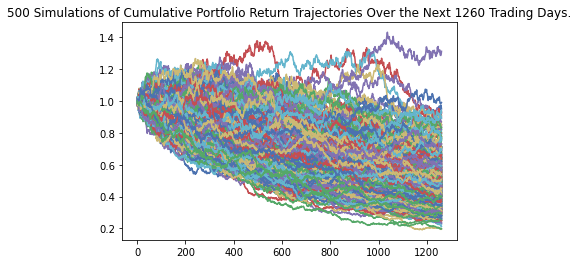

In [190]:
# Visualize the 30-year Monte Carlo simulation by creating an overlay line plot

# TODO: How come 30-year and 1260 Trading days? It has to be 1-year and 252 days period

line_plot_min_portfolio_plot = MC_min_portfolio.plot_simulation()

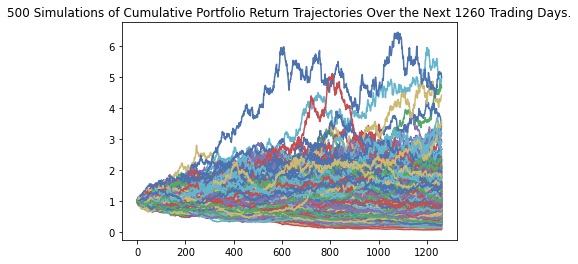

In [191]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
line_plot_max_portfolio_plot = MC_max_portfolio.plot_simulation()

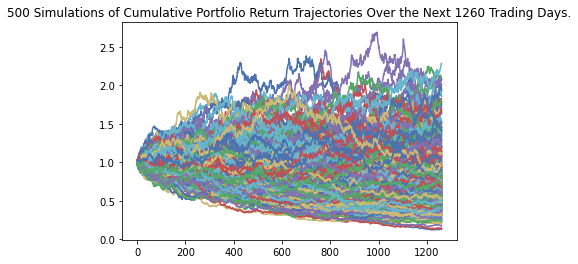

In [192]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
line_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_simulation()

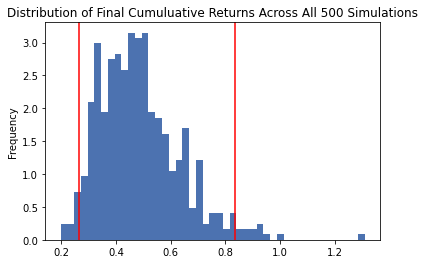

In [193]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
distribution_plot_min_portfolio_plot = MC_min_portfolio.plot_distribution()

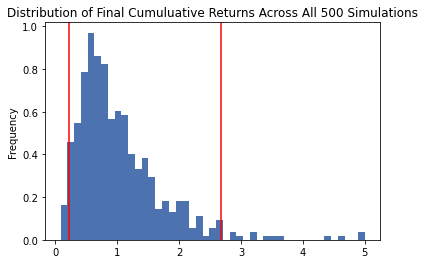

In [194]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
distribution_plot_max_portfolio_plot = MC_max_portfolio.plot_distribution()

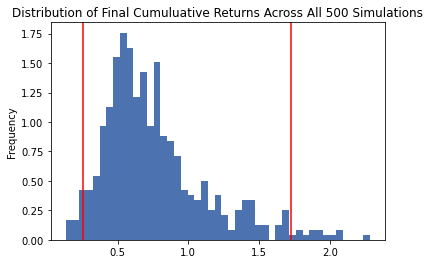

In [195]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
distribution_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_distribution()

In [196]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_min_portfolio_weight = MC_min_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_min_portfolio_weight)

count           500.000000
mean              0.484843
std               0.148877
min               0.196572
25%               0.374150
50%               0.464906
75%               0.563366
max               1.310693
95% CI Lower      0.264029
95% CI Upper      0.834685
Name: 1260, dtype: float64


In [197]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_max_portfolio_weight = MC_max_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_max_portfolio_weight)

count           500.000000
mean              1.029737
std               0.701197
min               0.086706
25%               0.559630
50%               0.843527
75%               1.319319
max               5.000227
95% CI Lower      0.229838
95% CI Upper      2.683457
Name: 1260, dtype: float64


In [198]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_opt_sharpe_ratio_portfolio_weight = MC_opt_sharpe_ratio_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_opt_sharpe_ratio_portfolio_weight)

count           500.000000
mean              0.762563
std               0.370665
min               0.134652
25%               0.514483
50%               0.675989
75%               0.906917
max               2.284915
95% CI Lower      0.258663
95% CI Upper      1.724347
Name: 1260, dtype: float64


In [199]:
# Print the initial investment in the portfolio
print(f"The initial investment of the portfolio is ${mpt.initial_test_investment:0.2f}")

The initial investment of the portfolio is $10000.00


In [200]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MIN portfolio

# Get the lower and upper CI values
ci_lower_95per = table_min_portfolio_weight[8]
ci_upper_95per = table_min_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2)

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current MIN portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_min:0.2f}")


There is a 95% chance that the current MIN portfolio value of $10000.00, will end within the range of $2640.29 and $8346.85.
The actual realized value of the portfolio is $7902.90


In [201]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MAX portfolio

# Get the lower and upper CI values
ci_lower_95per = table_max_portfolio_weight[8]
ci_upper_95per = table_max_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2)
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current MAX portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_max:0.2f}")


There is a 95% chance that the current MAX portfolio value of $10000.00, will end within the range of $2298.38 and $26834.57.
The actual realized value of the portfolio is $8842.97


In [202]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the OPT SHARPE RATIO portfolio

# Get the lower and upper CI values
ci_lower_95per = table_opt_sharpe_ratio_portfolio_weight[8]
ci_upper_95per = table_opt_sharpe_ratio_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current OPT Sharpe Ratio  portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_opt_sharpe_ratio:0.2f}")


There is a 95% chance that the current OPT Sharpe Ratio  portfolio value of $10000.00, will end within the range of $2586.63 and $17243.47.
The actual realized value of the portfolio is $8551.03


### 5. Summary